In [ ]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as optimize

## Definición de las acciones que componen el portafolio

## 100 Acciones componen el indice del Nasdaq
#assets = ['ADBE', 'AMD', 'ABNB', 'ALGN', 'GOOGL', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CHTR', 'CTAS', 'CSCO', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'EBAY', 'EA', 'ENPH', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LCID', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MNST', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PEP', 'PDD', 'QCOM', 'REGN', 'ROST', 'SGEN', 'SIRI', 'SBUX', 'SNPS', 'TMUS', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZM', 'ZS']
# Top 5 de acciones de portafolio optimo 
assets = ['SGEN', 'META', 'VRSK', 'CPRT', 'BKNG']

# Creación de un DataFrame vacío para almacenar los precios de cierre ajustados
data = pd.DataFrame()

# Descarga de datos históricos de las acciones
for t in assets:
    stock = yf.download(t, start='2023-01-01', end='2023-09-03')
    data[t] = stock['Adj Close']

# Cálculo de los rendimientos logarítmicos
log_returns = np.log(1 + data.pct_change())

# Listas para almacenar rendimientos y volatilidades generados al simular carteras
port_returns = []
port_vols = []

# Generación de carteras aleatorias para el análisis de eficiencia
for i in range(10000):
    num_assets = len(assets)
    
    # Generación de pesos aleatorios y normalización
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    # Cálculo del rendimiento y la volatilidad de la cartera simulada
    port_ret = np.sum(log_returns.mean() * weights) * 252
    port_var = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    
    # Almacenamiento de resultados en las listas correspondientes
    port_returns.append(port_ret)
    port_vols.append(port_var)

# Definición de una función para calcular estadísticas de cartera
def portfolio_stats(weights, log_returns):
    port_ret = np.sum(log_returns.mean() * weights) * 252
    port_var = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe = port_ret / port_var
    return {'Return': port_ret, 'Volatility': port_var, 'Sharpe': sharpe}

# Definición de la función objetivo para la optimización (maximización del coeficiente de Sharpe)
def minimize_negative_sharpe(weights, log_returns):
    return -portfolio_stats(weights, log_returns)['Sharpe']

# Conversión de listas a arrays para cálculos
port_returns = np.array(port_returns)
port_vols = np.array(port_vols)
sharpe = port_returns / port_vols

# Identificación del punto con el coeficiente de Sharpe máximo
max_sr_vol = port_vols[sharpe.argmax()]
max_sr_ret = port_returns[sharpe.argmax()]

# Definición de restricciones y límites para la optimización
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
num_assets = len(assets)
bounds = tuple((0, 1) for x in range(num_assets))
initializer = num_assets * [1. / num_assets, ]

# Optimización para encontrar la cartera óptima según el coeficiente de Sharpe
optimal_sharpe = optimize.minimize(minimize_negative_sharpe, initializer, method='SLSQP', args=(log_returns,), bounds=bounds, constraints=constraints)
optimal_sharpe_weights = optimal_sharpe['x'].round(4)
optimal_stats = portfolio_stats(optimal_sharpe_weights, log_returns)

# Impresión de los resultados de la cartera óptima
print("Pesos óptimos de la cartera: ", list(zip(assets, list(optimal_sharpe_weights * 100))))
print("Retorno óptimo de la cartera: ", round(optimal_stats['Return'] * 100, 4))
print("Volatilidad óptima de la cartera: ", round(optimal_stats['Volatility'] * 100, 4))
print("Ratio Sharpe óptimo de la cartera: ", round(optimal_stats['Sharpe'], 4))

# Gráfica de dispersión de carteras simuladas y resaltado de la cartera óptima
plt.figure(figsize=(12, 6))
plt.scatter(port_vols, port_returns, c=(port_returns / port_vols))
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=30)
plt.colorbar(label='Ratio Sharpe (rf=0)')
plt.xlabel('Volatilidad de la cartera')
plt.ylabel('Retorno de la cartera')
plt.title('Seminario Econometria financiera Optimización de Carteras con Modelo de Markowitz')
plt.show()

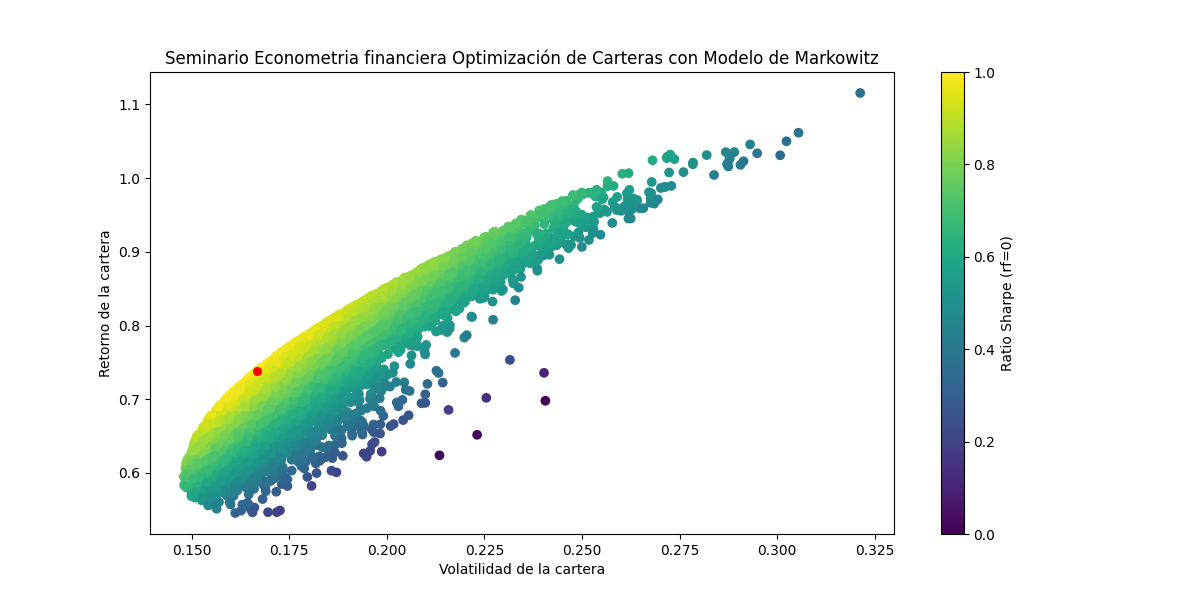

In [1]:
from IPython.display import Image

# Ruta a la imagen en tu sistema local o URL de una imagen en línea
imagen_path = 'portafolio.png'  # Cambia esto a la ruta correcta o URL

# Mostrar la imagen en el Jupyter Notebook
Image(filename=imagen_path)
